# Tutorial: Cryogen Evaporation Simulation with CryoEvap

## Introduction

This notebook will be use to simulate the isobaric evaporation with charge and discharge, with your own modifications to the base code of **CryoEvap**.

### What will you learn in this tutorial?

1. **Set up the environment**: Import the necessary modules  
2. **Define tank properties**: Geometry and heat transfer parameters  
3. **Configure the cryogen**: Use CoolProp to obtain thermodynamic properties  
4. **Modify inflow/outflow**: Implement charge (filling) and discharge (withdrawal) of Ammonia  
5. **Run the simulation**: Simulate isobaric evaporation under different operating scenarios  
6. **Visualize results**: Analyze temperature, volume, and evaporation rate plots  

---

## Case Study: Large-Scale Ammonia Storage with Dynamic Operation

We will simulate the evaporation and dynamic operation (charge/discharge) of **Ammonia** in a **165,000 m³** storage tank.

### Physical Context

In cryogenic storage tanks, heat from the environment enters the tank causing:
- **Liquid evaporation** (Boil-Off Gas - BOG)
- **Vapour superheating** in the ullage space
- **Charge/discharge cycles**: Liquid Ammonia is periodically added (charge) or withdrawn (discharge), affecting tank conditions and evaporation rates

---

> **In this tutorial, you will first modify the base code to allow for both charge and discharge of Ammonia. Then, you will simulate and compare different operational scenarios (e.g., continuous filling, periodic withdrawal, or combined cycles) to observe their impact on evaporation and tank performance.**

## Step 1: Environment Setup

First, we need to import the necessary libraries:
- **Tank**: Class representing the storage tank
- **Cryogen**: Class containing cryogen properties
- **numpy**: For numerical calculations
- **matplotlib**: For visualization

In [62]:
# Import the Tank class (storage tank)
from cryoevap.storage_tanks import Tank

# Import the Cryogen class
from cryoevap.cryogens import Cryogen

# Scientific computing library
import numpy as np

# Visualization library
import matplotlib.pyplot as plt

## Step 2: Define Tank and Cryogen Properties

In this section, we configure:
- **Tank geometry**: Internal/external diameter, volume
- **Heat transfer properties**: Overall heat transfer coefficients (U-values)
- **Operating conditions**: Ambient temperature, operating pressure, initial liquid filling
- **Define charge and discharge regimes**: Inflow and outflow function.

In [63]:
# ============================================
# TANK GEOMETRY
# ============================================
d_i = 60        # Internal diameter / m
d_o = 60        # External diameter / m
V_tank = 50000  # Tank volume / m^3

# ============================================
# HEAT TRANSFER PROPERTIES
# ============================================
# Overall heat transfer coefficient for liquid and vapour regions
U_L = 0.012  # Liquid phase / W/(m²·K)
U_V = 0.012  # Vapour phase / W/(m²·K)

# Heat ingress at roof and bottom
Q_roof = 0         # Roof heat ingress / W
Q_b    = 0     # Bottom heat input to prevent ground freezing / W

# Wall heat partitioning fraction (fraction of wall heat going to liquid)
eta_w = 0.8

# ============================================
# OPERATING CONDITIONS
# ============================================
T_air = 298.15     # Ambient temperature / K (25°C)
LF    = 0.5       # Initial liquid filling (50%)
P     = 101325     # Operating pressure / Pa 

### Setup charge and discharge regimes

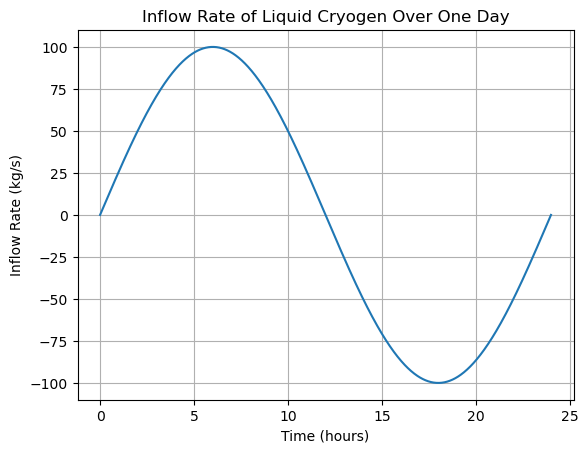

In [64]:
# ============================================
# SETUP INFLOW AND OUTFLOW RATES
# ============================================
period    = 24 * 3600  # Period of 24 hours in seconds
max_rate  = 100         # Amplitude of 10 kg/s
m_L_sin   = lambda t: max_rate * np.sin(2 * np.pi * t / period)
m_L_const = lambda t: max_rate / 100


# Plot the inflow rate over one period
time_array = np.linspace(0, period, 1000)
m_L_array = m_L_fun(time_array)
plt.plot(time_array / 3600, m_L_array)
plt.xlabel('Time (hours)')
plt.ylabel('Inflow Rate (kg/s)')
plt.title('Inflow Rate of Liquid Cryogen Over One Day')
plt.grid()
plt.show()

### Create the Tank instance

In [ ]:
# Create tank instance with your desire inflow/outflow rate function
large_tank = Tank(d_i, d_o, V_tank, LF, m_L=m_L_const)
large_tank.set_HeatTransProps(U_L, U_V, T_air, Q_b_fixed=Q_b, Q_roof=Q_roof, eta_w=eta_w)

### Configure the Cryogen

Now we create the cryogen (hydrogen/LH2) and set its thermodynamic properties using **CoolProp**.

In [54]:
# Create and configure the cryogen
hydrogen = Cryogen(name="Ammonia")
hydrogen.set_coolprops(P)  # Set properties using CoolProp at pressure P

# Assign cryogen to tank
large_tank.cryogen = hydrogen

## Step 3: Calculate Initial Evaporation Rate

Before running the full simulation, let's examine the initial conditions:

In [55]:
# Display cryogen properties
print("=" * 50)
print("CRYOGEN PROPERTIES (Hydrogen at P = %.0f Pa)" % P)
print("=" * 50)
print(f"Saturation temperature: {hydrogen.T_sat:.2f} K ({hydrogen.T_sat - 273.15:.2f} °C)")
print(f"Liquid density: {hydrogen.rho_L:.2f} kg/m³")
print(f"Vapour density: {hydrogen.rho_V:.4f} kg/m³")

# Calculate and display evaporation metrics
print("\n" + "=" * 50)
print("INITIAL EVAPORATION")
print("=" * 50)
print(f"Initial evaporation rate: {large_tank.b_l_dot * 3600:.1f} kg/h")
print(f"Transient period (τ): {large_tank.tau:.0f} s ({large_tank.tau/3600:.1f} h)")

# Calculate Boil-Off Rate (BOR)
BOR = (large_tank.b_l_dot * 24 * 3600) / (large_tank.V * large_tank.LF * large_tank.cryogen.rho_L)
print(f"Boil-Off Rate (BOR): {BOR * 100:.4f} %/day")

CRYOGEN PROPERTIES (Hydrogen at P = 101325 Pa)
Saturation temperature: 239.83 K (-33.32 °C)
Liquid density: 681.63 kg/m³
Vapour density: 0.8900 kg/m³

INITIAL EVAPORATION
Initial evaporation rate: 5.5 kg/h
Transient period (τ): 29031830 s (8064.4 h)
Boil-Off Rate (BOR): 0.0008 %/day


## Step 4: Run the Evaporation Simulation

Now we configure and run the transient evaporation simulation. Key parameters:
- **Spatial discretization**: Number of nodes for the vapour temperature profile
- **Simulation time**: Total evaporation time (48 weeks for long-term storage)
- **Time intervals**: For data recording and plotting

In [56]:
# ============================================
# SPATIAL DISCRETIZATION
# ============================================
dz  = 0.1  # Vertical spacing / m
n_z = 1 + int(np.round(large_tank.l_V / dz, 0))  # Number of nodes
large_tank.z_grid = np.linspace(0, 1, n_z)       # Dimensionless grid

print(f"Vapour space height: {large_tank.l_V:.2f} m")
print(f"Number of grid nodes: {n_z}")

# ============================================
# BOUNDARY CONDITIONS
# ============================================
large_tank.U_roof = 0  # Insulated roof 

# ============================================
# TIME PARAMETERS
# ============================================
evap_time                = 3600 * 24 * 7   # Simulation time: 1 week in seconds
large_tank.time_interval = 3600            # Record data every hour
large_tank.plot_interval = evap_time / 6   # Plot 6 temperature profiles

# ============================================
# RUN SIMULATION
# ============================================
large_tank.evaporate(evap_time)


Vapour space height: 8.84 m
Number of grid nodes: 89


## Step 5: Visualization of Results

The `Tank` class includes several built-in plotting methods to visualize the simulation results.

### 5.1 Vapour Temperature Profile

This plot shows the evolution of the vapour temperature profile in the ullage space over time.

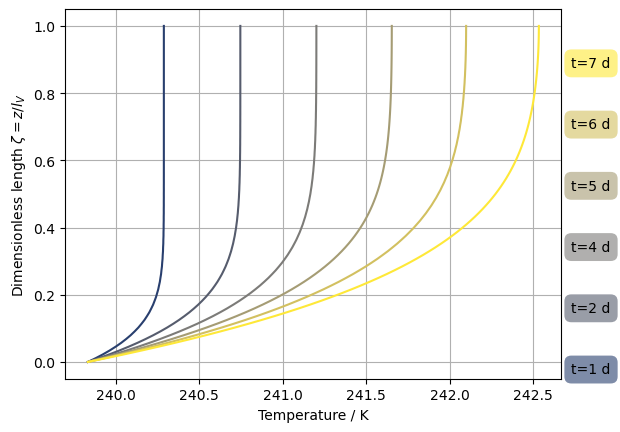

In [57]:
# Plot vapour temperature profiles (t_unit='w' for weeks)
large_tank.plot_tv(t_unit='d')

### 5.2 Heat Transfer Rates

Visualize the heat ingress rates:
- $\dot{Q}_{\text{L}}$: Heat transfer to the liquid phase
- $\dot{Q}_{\text{V}}$: Heat transfer to the vapour phase
- $\dot{Q}_{VL}$: Heat transfer from vapour to liquid interface
- $\dot{Q}_{\text{V,w}}$: Fraction of wall heat transferred directly to the interface

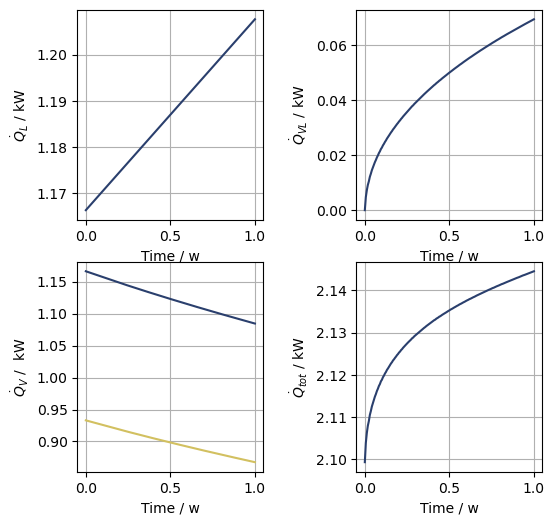

In [58]:
# Plot heat transfer rates (unit='kW', t_unit='w' for weeks)
large_tank.plot_Q(unit='kW', t_unit='w')

### 5.3 Liquid Volume Evolution

Track the decrease in liquid volume over time due to evaporation.

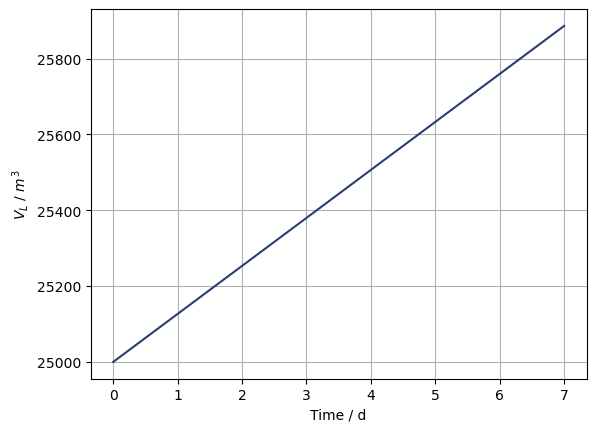

In [59]:
# Plot liquid volume over time
large_tank.plot_V_L(t_unit='d')

### 5.4 Boil-Off Gas (BOG) Rate

The BOG rate shows the mass flow rate of evaporated cryogen over time.

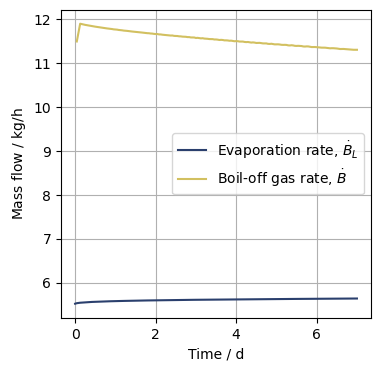

In [60]:
# Plot BOG rate (unit='kg/h', t_unit='d' for days, 'w' for weeks, 'h' for hours)
large_tank.plot_BOG(unit='kg/h', t_unit='d')

### 5.5 Vapour and BOG temperature

This plot shows the relationship between the average vapour temperature and the BOG temperature at the tank outlet, illustrating how vapour superheating evolves during the evaporation process.

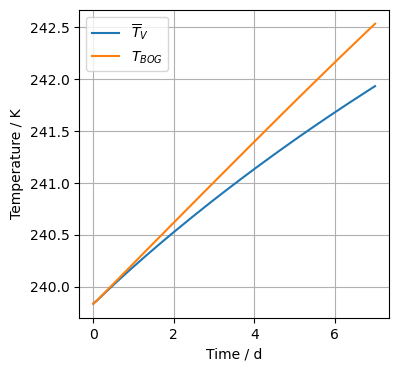

In [61]:
# Plot temperature vs BOG tenperature
large_tank.plot_tv_BOG(t_unit='d')

### References
F. Huerta, V. Vesovic, A realistic vapour phase heat transfer model for the weathering of LNG stored in large tanks, Energy, 174 (2019) 280-291.